# Introduction to Apache Spark lab, part 2: Querying data
This notebook guides you through querying data with Apache Spark, including how to create and use DataFrames, run SQL queries, apply functions to the results of SQL queries, join data from different data sources, and visualize data in graphs.

This notebook uses pySpark, the Python API for Spark. Some knowledge of Python is recommended. This notebook runs on Python 2 with Spark 1.6 and 2.0.

If you are new to Apache Spark, see the first module in this series: [Introduction to Apache Spark, part 1: Basic Concepts](https://apsportal.ibm.com/exchange/public/entry/view/95811fca38af4ccbea8acf8658bedcfc). 

## Table of contents

1. [Prepare the environment and the data](#getstarted)<br>
     1.1 [Enable SQL processing](#sqlprocessing)<br>
     1.2 [Download the data](#download)<br>
     1.3 [Create a DataFrame](#createdf)<br>
     1.4 [Create a table](#createtab)<br>
2. [Run SQL queries](#runsql)<br>
    2.1 [Display query results with a pandas DataFrame](#pandas)<br>
    2.2 [Run a group by query](#groupby)<br>
    2.3 [Run a subselect query](#subselect)<br>
    2.4 [Return nested JSON field values](#nested)<br>
3. [Convert RDDs to DataFrames](#convertrdd)<br>
    3.1 [Create a simple RDD](#simplerdd)<br>
    3.2 [Apply a schema](#apply)<br>
    3.3 [Create rows with named columns](#namedcol)<br>
    3.4 [Join tables](#join)<br>
4. [Create SQL functions](#sqlfuncs)<br>
5. [Convert a pandas DataFrame to a Spark DataFrame](#sparkdf)<br>
    5.1 [Get a new data set](#ufo)<br>
    5.2 [Create a pandas DataFrame](#ufopandas)<br>
    5.3 [Convert to a Spark DataFrame](#sparkufo)<br>
    5.4 [Run an SQL statement](#runufo)<br>
6. [Visualize data](#viz)<br>
    6.1 [Create a chart](#vizchart)<br>
    6.2 [Aggregate the data](#vizagg)<br>
    6.3 [Create a better chart](#vizchart2)<br>
7. [Summary and next steps](#nextsteps)

<a id="getstarted"></a>
## 1. Prepare the environment and the data
Before you can run SQL queries on data in an Apache Spark environment, you need to enable SQL processing and then move the data to the structured format of a DataFrame.

<a id="sqlprocessing"></a>
### 1.1 Enable SQL processing
The way you enable SQL processing with Spark 1.6 is to create an SQLContext. With Spark 2.0, the preferred method is to use the new SparkSession object, but the SQLContext object is still supported. 

Use the predefined Spark Context, `sc`, which contains the connection information for Spark, to create an SQLContext:

In [21]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

<a id="download"></a>
### 1.2 Download the data file

You'll download a JSON file with data about world banks from GitHub. The data is adapted from this data set: [http://data.worldbank.org/data-catalog/projects-portfolio](http://data.worldbank.org/data-catalog/projects-portfolio).

Remove any files with the same name as the file that you're going to download and then download the file from a URL:

In [22]:
!rm world_bank.json.gz -f
!wget https://raw.githubusercontent.com/bradenrc/sparksql_pot/master/world_bank.json.gz

--2017-01-09 11:14:50--  https://raw.githubusercontent.com/bradenrc/sparksql_pot/master/world_bank.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446287 (436K) [application/octet-stream]
Saving to: ‘world_bank.json.gz’

100%[======================================>] 446,287     --.-K/s   in 0.02s   

2017-01-09 11:14:50 (17.7 MB/s) - ‘world_bank.json.gz’ saved [446287/446287]



<a id="createdf"></a>
### 1.3 Create a DataFrame 

Instead of creating an RDD to read the file, you'll create a Spark DataFrame. Unlike an RDD, a DataFrame creates a schema around the data, which supplies the necessary structure for SQL queries. A self-describing format like JSON is ideal for DataFrames, but many other file types are supported, including text (CSV) and Parquet.

Create a DataFrame:

In [23]:
example1_df = sqlContext.read.json("world_bank.json.gz")

Print the schema to see how Spark SQL inferred the shape of the data:

In [24]:
print example1_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- approvalfy: string (nullable = true)
 |-- board_approval_month: string (nullable = true)
 |-- boardapprovaldate: string (nullable = true)
 |-- borrower: string (nullable = true)
 |-- closingdate: string (nullable = true)
 |-- country_namecode: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- countryname: string (nullable = true)
 |-- countryshortname: string (nullable = true)
 |-- docty: string (nullable = true)
 |-- envassesmentcategorycode: string (nullable = true)
 |-- grantamt: long (nullable = true)
 |-- ibrdcommamt: long (nullable = true)
 |-- id: string (nullable = true)
 |-- idacommamt: long (nullable = true)
 |-- impagency: string (nullable = true)
 |-- lendinginstr: string (nullable = true)
 |-- lendinginstrtype: string (nullable = true)
 |-- lendprojectcost: long (nullable = true)
 |-- majorsector_percent: array (nullable = true)
 |    |-- element: struct (containsNu

Now look at the first two rows of data.

You can run the simple command `print example1_df.take(2)`, however, for readability, run the following command to include a row of asterisks in between the data rows:

In [25]:
for row in example1_df.take(2):
    print row
    print "*" * 20

Row(_id=Row($oid=u'52b213b38594d8a2be17c780'), approvalfy=u'1999', board_approval_month=u'November', boardapprovaldate=u'2013-11-12T00:00:00Z', borrower=u'FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA', closingdate=u'2018-07-07T00:00:00Z', country_namecode=u'Federal Democratic Republic of Ethiopia!$!ET', countrycode=u'ET', countryname=u'Federal Democratic Republic of Ethiopia', countryshortname=u'Ethiopia', docty=u'Project Information Document,Indigenous Peoples Plan,Project Information Document', envassesmentcategorycode=u'C', grantamt=0, ibrdcommamt=0, id=u'P129828', idacommamt=130000000, impagency=u'MINISTRY OF EDUCATION', lendinginstr=u'Investment Project Financing', lendinginstrtype=u'IN', lendprojectcost=550000000, majorsector_percent=[Row(Name=u'Education', Percent=46), Row(Name=u'Education', Percent=26), Row(Name=u'Public Administration, Law, and Justice', Percent=16), Row(Name=u'Education', Percent=12)], mjsector_namecode=[Row(code=u'EX', name=u'Education'), Row(code=u'EX', name=u'E

<a id="createtab"></a>
### 1.4 Create a table 

SQL statements must be run against a table. Create a table that's a pointer to the DataFrame:

In [26]:
example1_df.registerTempTable("world_bank")

<a id="runsql"></a>
## 2. Run SQL queries

You must define a new DataFrame for the results of the SQL query and put the SQL statement inside the `sqlContext.sql()` method.

Run the following cell to select all columns from the table and print information about the resulting DataFrame and schema of the data:

In [27]:
temp_df =  sqlContext.sql("select * from world_bank")

print type(temp_df)
print "*" * 20
print temp_df

<class 'pyspark.sql.dataframe.DataFrame'>
********************
DataFrame[_id: struct<$oid:string>, approvalfy: string, board_approval_month: string, boardapprovaldate: string, borrower: string, closingdate: string, country_namecode: string, countrycode: string, countryname: string, countryshortname: string, docty: string, envassesmentcategorycode: string, grantamt: bigint, ibrdcommamt: bigint, id: string, idacommamt: bigint, impagency: string, lendinginstr: string, lendinginstrtype: string, lendprojectcost: bigint, majorsector_percent: array<struct<Name:string,Percent:bigint>>, mjsector_namecode: array<struct<code:string,name:string>>, mjtheme: array<string>, mjtheme_namecode: array<struct<code:string,name:string>>, mjthemecode: string, prodline: string, prodlinetext: string, productlinetype: string, project_abstract: struct<cdata:string>, project_name: string, projectdocs: array<struct<DocDate:string,DocType:string,DocTypeDesc:string,DocURL:string,EntityID:string>>, projectfinancialty

The first `print` command shows that the DataFrame is a Spark DataFrame. The last `print` command shows the column names and data types of the DataFrame.

<a id="pandas"></a>
### 2.1 Display query results with a pandas DataFrame
The `print` command doesn't show the data in a useful format. Instead of creating a Spark DataFrame, use the pandas open-source data analytics library to create a pandas DataFrame that shows the data in a table. 

Import the pandas library and use the `.toPandas()` method to show the query results:

In [28]:
import pandas as pd
sqlContext.sql("select id, borrower from world_bank limit 2").toPandas()

,id,borrower
0,P129828,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA
1,P144674,GOVERNMENT OF TUNISIA


<a id="groupby"></a>
### 2.2 Run a group by query

You can make your SQL queries easier to read by using the `query` keyword and surrounding the SQL query with `"""` on separate lines. 

Calculate a count of projects by region:

In [29]:
query = """
select
    regionname ,
    count(*) as project_count
from world_bank
group by regionname 
order by count(*) desc
"""

sqlContext.sql(query).toPandas()

,regionname,project_count
0,Africa,152
1,East Asia and Pacific,100
2,Europe and Central Asia,74
3,South Asia,65
4,Middle East and North Africa,54
5,Latin America and Caribbean,53
6,Other,2


<a id="subselect"></a>
### 2.3 Run a subselect query
You can run subselect queries.

Calculate a count of projects by region again, but this time using a subselect:

In [30]:
query = """

select * from
    (select
        regionname ,
        count(*) as project_count
    from world_bank
    group by regionname 
    order by count(*) desc) table_alias
limit 2
"""

sqlContext.sql(query).toPandas()

,regionname,project_count
0,Africa,152
1,East Asia and Pacific,100


<a id="nested"></a>
### 2.4 Return nested JSON field values
With JSON data, you can select the values of nested fields with dot notation.

Print the schema so that you can see that `sector.Name` is a nested field and then select its first two values:

In [31]:
example1_df.printSchema()

sql = "select sector.Name from world_bank limit 2"
sqlContext.sql(sql).show()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- approvalfy: string (nullable = true)
 |-- board_approval_month: string (nullable = true)
 |-- boardapprovaldate: string (nullable = true)
 |-- borrower: string (nullable = true)
 |-- closingdate: string (nullable = true)
 |-- country_namecode: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- countryname: string (nullable = true)
 |-- countryshortname: string (nullable = true)
 |-- docty: string (nullable = true)
 |-- envassesmentcategorycode: string (nullable = true)
 |-- grantamt: long (nullable = true)
 |-- ibrdcommamt: long (nullable = true)
 |-- id: string (nullable = true)
 |-- idacommamt: long (nullable = true)
 |-- impagency: string (nullable = true)
 |-- lendinginstr: string (nullable = true)
 |-- lendinginstrtype: string (nullable = true)
 |-- lendprojectcost: long (nullable = true)
 |-- majorsector_percent: array (nullable = true)
 |    |-- element: struct (containsNu

<a id="convertrdd"></a>
## 3. Convert RDDs to DataFrames
If you want to run SQL queries on an existing RDD, you must convert the RDD to a DataFrame. The main difference between RDDs and DataFrames is whether the columns are named.

You'll create an RDD and then convert it to a DataFrame in two different ways:
 - [Apply a schema](#apply)
 - [Create rows with named columns](#namedcol)

<a id="simplerdd"></a>
### 3.1 Create a simple RDD
You'll create a simple RDD with an ID column and two columns of random numbers.

First create a Python list of lists:

In [32]:
import random

data_e2 = []
for x in range(1,6):
    random_int = int(random.random() * 10)
    data_e2.append([x, random_int, random_int^2])

Now create the RDD:

In [33]:
rdd_example2 = sc.parallelize(data_e2)
print rdd_example2.collect()

[[1, 9, 11], [2, 4, 6], [3, 2, 0], [4, 1, 3], [5, 2, 0]]


<a id="apply"></a>
### 3.2 Apply a schema
You'll use the `StructField` method to create a schema object that's based on a string, apply the schema to the RDD to create a DataFrame, and then create a table to run SQL queries on.

Define your schema columns as a string:

In [34]:
from pyspark.sql.types import *

schemaString = "ID VAL1 VAL2"

Assign header information with the `StructField` method and create the schema with the `StructType` method:

In [35]:
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)

Apply the schema to the RDD with the `createDataFrame` method:

In [36]:
schemaExample = sqlContext.createDataFrame(rdd_example2, schema)

Register the DataFrame as a table:

In [37]:
schemaExample.registerTempTable("example2")

View the data:

In [38]:
print schemaExample.collect()

[Row(ID=u'1', VAL1=u'9', VAL2=u'11'), Row(ID=u'2', VAL1=u'4', VAL2=u'6'), Row(ID=u'3', VAL1=u'2', VAL2=u'0'), Row(ID=u'4', VAL1=u'1', VAL2=u'3'), Row(ID=u'5', VAL1=u'2', VAL2=u'0')]


You can reference the columns names in DataFrames:

In [39]:
for row in schemaExample.take(2):
    print row.ID, row.VAL1, row.VAL2

1 9 11
2 4 6


Run a simple SQL query:

In [40]:
sqlContext.sql("select * from example2").toPandas()

,ID,VAL1,VAL2
0,1,9,11
1,2,4,6
2,3,2,0
3,4,1,3
4,5,2,0


<a id="namedcol"></a>
### 3.3 Create rows with named columns
You'll create an RDD with named columns and then convert it to a DataFrame and a table.

Create a new RDD and specify the names of the columns with the `map` method:

In [41]:
from pyspark.sql import Row

rdd_example3 = rdd_example2.map(lambda x: Row(id=x[0], val1=x[1], val2=x[2]))

print rdd_example3.collect()                                                            

[Row(id=1, val1=9, val2=11), Row(id=2, val1=4, val2=6), Row(id=3, val1=2, val2=0), Row(id=4, val1=1, val2=3), Row(id=5, val1=2, val2=0)]


Convert `rdd_example3` to a DataFrame and register an associated table:

In [42]:
df_example3 = rdd_example3.toDF()
df_example3.registerTempTable("example3")

Run a simple SQL query:

In [43]:
sqlContext.sql("select * from example3").toPandas()

,id,val1,val2
0,1,9,11
1,2,4,6
2,3,2,0
3,4,1,3
4,5,2,0


<a id="join"></a>
### 3.4 Join tables
You can join tables.

Join tables `example2` and `example3` on the ID column:

In [44]:
query = """
select
    *
from
    example2 e2
inner join example3 e3 on
    e2.ID = e3.id
"""

print sqlContext.sql(query).toPandas()

  ID VAL1 VAL2  id  val1  val2
0  1    9   11   1     9    11
1  3    2    0   3     2     0
2  5    2    0   5     2     0
3  4    1    3   4     1     3
4  2    4    6   2     4     6


Alternatively, you can join DataFrames with a Python command instead of an SQL query:

In [45]:
df_example4 = df_example3.join(schemaExample, schemaExample["ID"] == df_example3["id"] )

for row in df_example4.take(5):
    print row

Row(id=1, val1=9, val2=11, ID=u'1', VAL1=u'9', VAL2=u'11')
Row(id=3, val1=2, val2=0, ID=u'3', VAL1=u'2', VAL2=u'0')
Row(id=5, val1=2, val2=0, ID=u'5', VAL1=u'2', VAL2=u'0')
Row(id=4, val1=1, val2=3, ID=u'4', VAL1=u'1', VAL2=u'3')
Row(id=2, val1=4, val2=6, ID=u'2', VAL1=u'4', VAL2=u'6')


<a id="sqlfuncs"></a>
## 4. Create SQL functions 
You can create functions that run in SQL queries. 

First, create a Python function and test it:

In [46]:
def simple_function(v):
    return int(v * 10)

#test the function
print simple_function(3)

30


Next, register the function as an SQL function with the `registerFunction` method:

In [47]:
sqlContext.registerFunction("simple_function", simple_function)

Now run the function in an SQL Statement:

In [48]:
query = """
select
    ID,
    VAL1,
    VAL2,
    simple_function(VAL1) as s_VAL1,
    simple_function(VAL2) as s_VAL2
from
 example2
"""
sqlContext.sql(query).toPandas()

,ID,VAL1,VAL2,s_VAL1,s_VAL2
0,1,9,11,9999999999,11111111111111111111
1,2,4,6,4444444444,6666666666
2,3,2,0,2222222222,0
3,4,1,3,1111111111,3333333333
4,5,2,0,2222222222,0


The values in the VAL1 and VAL2 columns look like strings (10 characters instead of a number multiplied by 10). That's because string is the default data type for columns in Spark DataFrames.

Cast the values in the VAL1 and VAL2 columns to integers: 

In [49]:
query = """
select
    ID,
    VAL1,
    VAL2,
    simple_function(cast(VAL1 as int)) as s_VAL1,
    simple_function(cast(VAL2 as int)) as s_VAL2
from
 example2
"""
sqlContext.sql(query).toPandas()

,ID,VAL1,VAL2,s_VAL1,s_VAL2
0,1,9,11,90,110
1,2,4,6,40,60
2,3,2,0,20,0
3,4,1,3,10,30
4,5,2,0,20,0


That looks better!

<a id="sparkdf"></a>
## 5. Convert a pandas DataFrame to a Spark DataFrame
Although pandas DataFrames display data in a friendlier format, Spark DataFrames can be faster and more scalable.

You'll get a new data set, create a pandas DataFrame for it, and then convert the pandas DataFrame to a Spark DataFrame.

<a id="ufo"></a>
### 5.1 Get a new data set
Get a data set about UFO sightings:

In [50]:
!rm SIGHTINGS.csv -f
!wget https://www.quandl.com/api/v3/datasets/NUFORC/SIGHTINGS.csv

--2017-01-09 11:15:13--  https://www.quandl.com/api/v3/datasets/NUFORC/SIGHTINGS.csv
Resolving www.quandl.com (www.quandl.com)... 104.25.53.103, 104.25.54.103, 2400:cb00:2048:1::6819:3567, ...
Connecting to www.quandl.com (www.quandl.com)|104.25.53.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14354 (14K) [text/csv]
Saving to: ‘SIGHTINGS.csv’

100%[======================================>] 14,354      --.-K/s   in 0.001s  

2017-01-09 11:15:14 (25.7 MB/s) - ‘SIGHTINGS.csv’ saved [14354/14354]



<a id="ufopandas"></a>
### 5.2 Create a pandas DataFrame
Create a pandas DataFrame of the data set with the `read_csv` method:

In [51]:
pandas_df = pd.read_csv("./SIGHTINGS.csv")
pandas_df.head()

,Reports,Count
0,2017-01-31,40
1,2016-12-31,317
2,2016-11-30,478
3,2016-10-31,471
4,2016-09-30,582


<a id="sparkufo"></a>
### 5.3 Convert to a Spark DataFrame
Convert the pandas DataFrame to a Spark DataFrame with the `createDataFrame` method. Remember using the `createDataFrame` method to convert an RDD to a Spark DataFrame?

In [52]:
spark_df = sqlContext.createDataFrame(pandas_df)

Print the first two rows:

In [53]:
for row in spark_df.take(2):
    print row


Row(Reports=u'2017-01-31', Count=40.0)
Row(Reports=u'2016-12-31', Count=317.0)


Register the Spark DataFrame as a table:

In [54]:
spark_df.registerTempTable("ufo_sightings")

<a id="runufo"></a>
### 5.4 Run an SQL statement
Now run an SQL statement to print the first 10 rows of the table:

In [55]:
print sqlContext.sql("select * from ufo_sightings limit 10").collect()

[Row(Reports=u'1979-07-31', Count=40.0), Row(Reports=u'1979-06-30', Count=72.0), Row(Reports=u'1979-05-31', Count=16.0), Row(Reports=u'1979-04-30', Count=18.0), Row(Reports=u'1979-03-31', Count=14.0), Row(Reports=u'1979-02-28', Count=11.0), Row(Reports=u'1979-01-31', Count=11.0), Row(Reports=u'1978-12-31', Count=15.0), Row(Reports=u'1978-11-30', Count=21.0), Row(Reports=u'1978-10-31', Count=28.0)]


<a id="viz"></a>
## 6. Visualize data
It's easy to create charts from pandas DataFrames. You'll use the matplotlib library to create graphs and the NumPy package for computing.

Import the libraries and specify to show graphs inline:

In [56]:
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

Convert the Spark DataFrame with UFO data to a pandas DataFrame: 

In [57]:
ufos_df = spark_df.toPandas()

<a id="vizchart"></a>
### 6.1 Create a chart

To create a chart, you call the `plot()` method and specify the type of chart, the columns for the X and Y axes, and, optionally, the size of the chart. 

For more information about plotting pandas DataFrames, see [Visualization](http://pandas.pydata.org/pandas-docs/stable/visualization.html).

Create a bar chart 12" wide by 5" high that shows the number of reports by date:

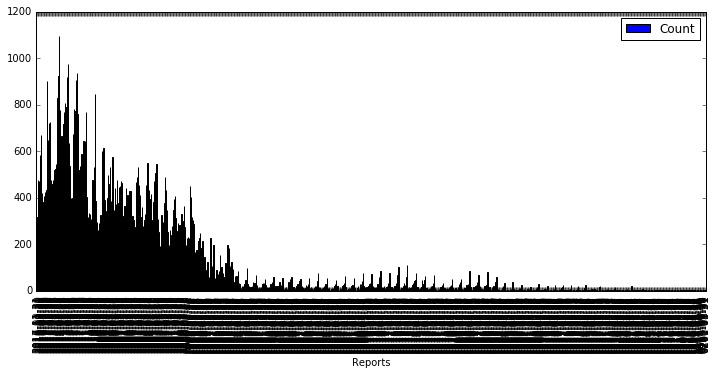

In [58]:
ufos_df.plot(kind='bar', x='Reports', y='Count', figsize=(12, 5))

This chart doesn't look good because there are too many observations. Check how many observations there are by querying the `ufo_sightings` table:

In [59]:
print sqlContext.sql("select count(*) from ufo_sightings").collect()

[Row(_c0=902)]


<a id="vizagg"></a>
### 6.2 Aggregate the data

To reduce the number of data points on the chart, you can aggregate the data by year. Here are a few of the ways that you can do that:

 - Run an SQL query on the Reports column to output the year, and then run a group by operation on the year.
 - Create a simple Python function to aggregate by year, and then run the function in an SQL query.
 - Run the `map()` method on the Spark Dataframe to append a new column that contains the aggregated count by year. This is the method you'll use.

Remember that the dates in the Reports column look like this: 2016-01-31. Therefore, to create the year column, you just need the first 4 characters from the Reports column.

Add a year column to the DataFrame:

In [60]:
ufos_df = spark_df.rdd.map(lambda x: Row(**dict(x.asDict(), year=int(x.Reports[0:4])))).toDF()

Check to verify that you get the expected results:

In [61]:
print ufos_df.take(5)

[Row(Count=40.0, Reports=u'2017-01-31', year=2017), Row(Count=317.0, Reports=u'2016-12-31', year=2016), Row(Count=478.0, Reports=u'2016-11-30', year=2016), Row(Count=471.0, Reports=u'2016-10-31', year=2016), Row(Count=582.0, Reports=u'2016-09-30', year=2016)]


Register the DataFrame as a table:

In [62]:
ufos_df.registerTempTable("ufo_withyear")

<a id="vizchart2"></a>
### 6.3 Create a better chart

Now run an SQL query to group by year, order by year, and filter to the last 66 years. Then create a pandas DataFrame for the results and create a chart of the number of reports by year.

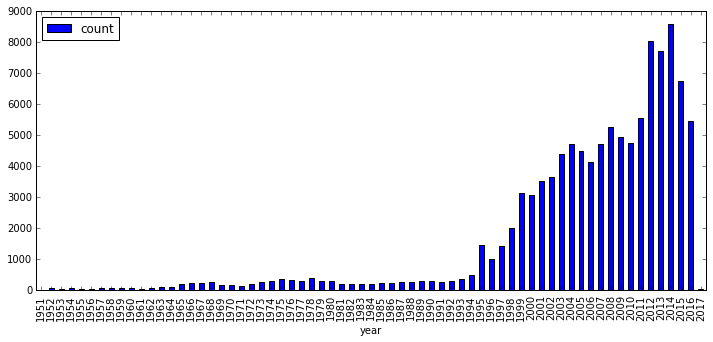

In [63]:
query = """
select 
    sum(Count) as count, 
    year 
from ufo_withyear
where year > 1950
group by year
order by year
"""
pandas_ufos_withyears = sqlContext.sql(query).toPandas()
pandas_ufos_withyears.plot(kind='bar', x='year', y='count', figsize=(12, 5))

Now you have a chart that you can read. Look back at the original chart and notice that it wasn't ordered ascending by year.

<a id="nextsteps"></a>
## 7. Summary and next steps
You've learned how to create DataFrames, convert between DataFrame types, and convert from RDDs. You know how to run SQL queries and create SQL functions. And you can visualize the data in charts. 

Go to the next notebook in this series: [Introduction to Apache Spark lab, part 3: Machine learning](https://apsportal.ibm.com/exchange/public/entry/view/5ad1c820f57809ddec9a040e37b4af08).

Dig deeper:
 - [Apache Spark documentation](http://spark.apache.org/documentation.html)
 - [PySpark documentation](http://spark.apache.org/docs/latest/api/python/pyspark.html)
 - [pandas](http://pandas.pydata.org/pandas-docs/stable/index.html)
 - [matplotlib](http://matplotlib.org/)
 - [NumPy](http://www.numpy.org/)

### Authors
Carlo Appugliese is a Spark and Hadoop evangelist at IBM.<br>
Braden Callahan is a Big Data Technical Specialist for IBM.<br>
Ross Lewis is a Big Data Technical Sales Specialist for IBM.<br>
Mokhtar Kandil is a World Wide Big Data Technical Specialist for IBM.

### Data citation

The World Bank: Projects & Operations 

<hr>
Copyright &copy; IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.